# News Articles Analysis

The following project was an assignment for the lesson of Data Mining Techniques.

### Notes:
- Make sure to run *generate_train_test_sets.ipynb* to create the train/test sets, test categories set as tsv files as well as a tsv file containing all of our dataset, which will be used only for wordclouds.

### Import the whole dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data.tsv", sep='\t', encoding = 'ANSI')

# 1. Word Clouds per Category

In [2]:
from wordcloud import WordCloud

Generate a string containing all the words from a specific column of our dataframe:

In [ ]:
def choose_category_content(category: str) -> str:
    articles_series = df[df['category'] == category]['content']
    words = ' '.join(articles_series)
    return words

Now we need to make a wordcloud generator for an article's category:

In [3]:


def wordcloud_gen(category):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "white",
        min_font_size = 10).generate(choose_category_content(category))

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Business Word Cloud

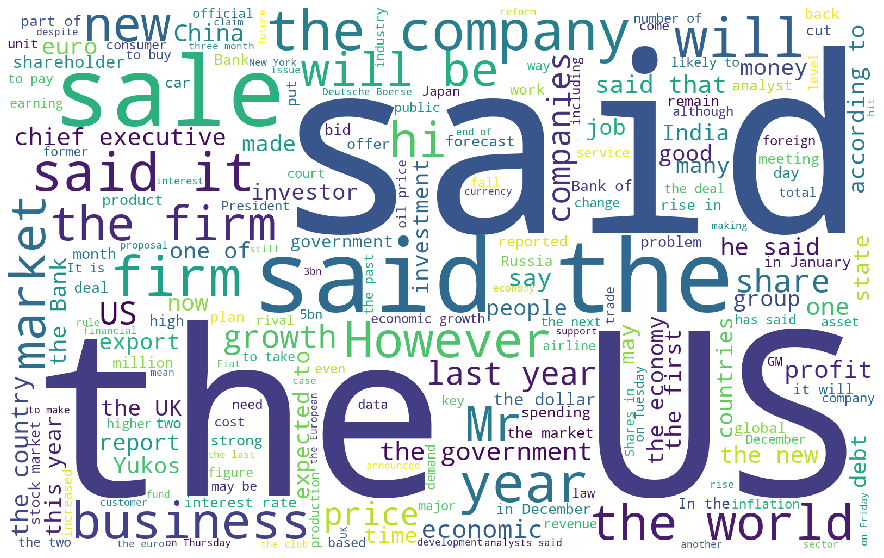

In [4]:
wordcloud_gen("business")

### Entertainment Word Cloud

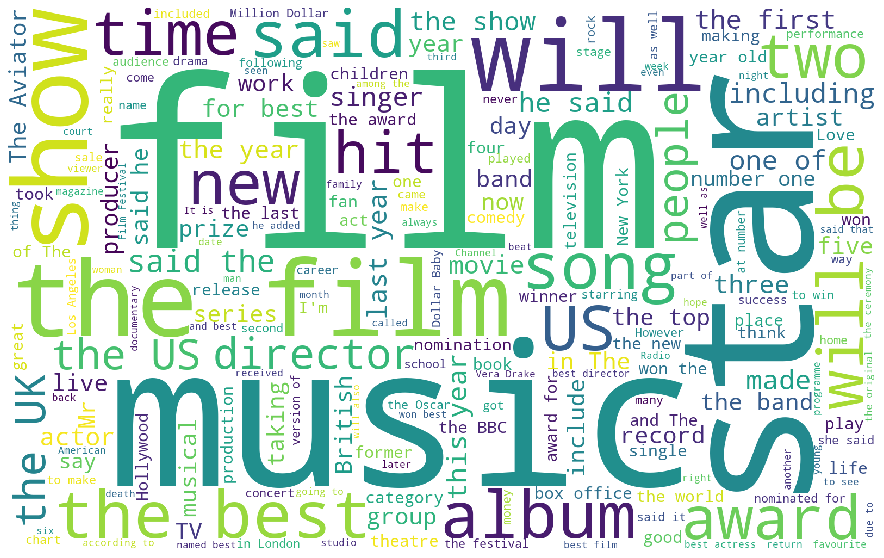

In [5]:
wc = wordcloud_gen("entertainment")

### Politics Word Cloud

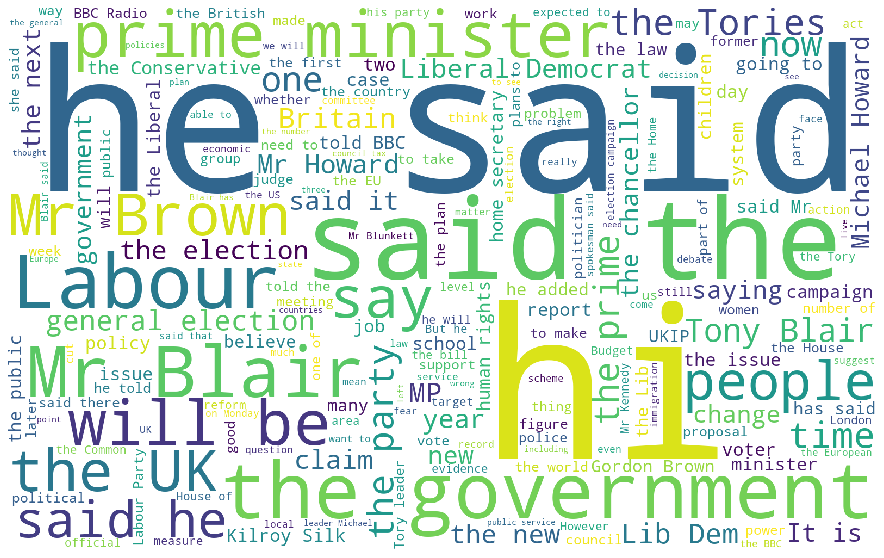

In [6]:
wc = wordcloud_gen("politics")

### Sport Word Cloud

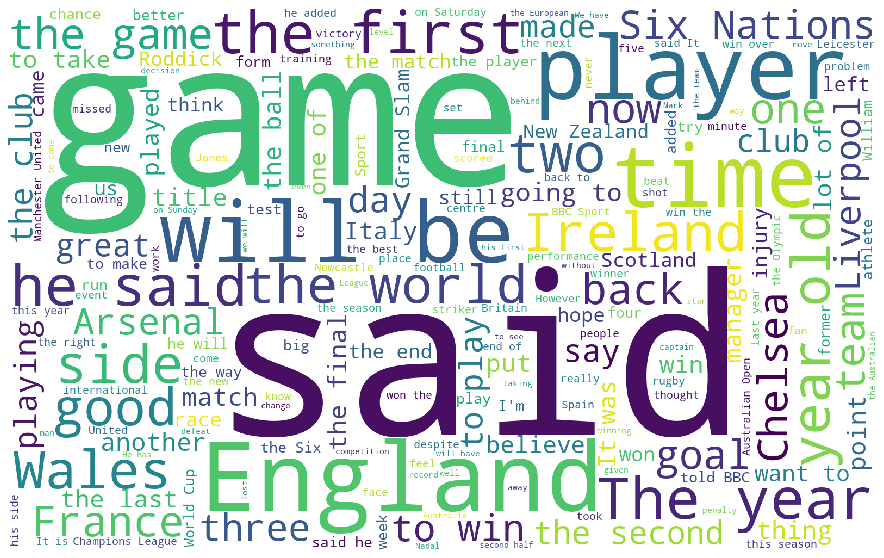

In [7]:
wc = wordcloud_gen("sport")

### Tech Word Cloud

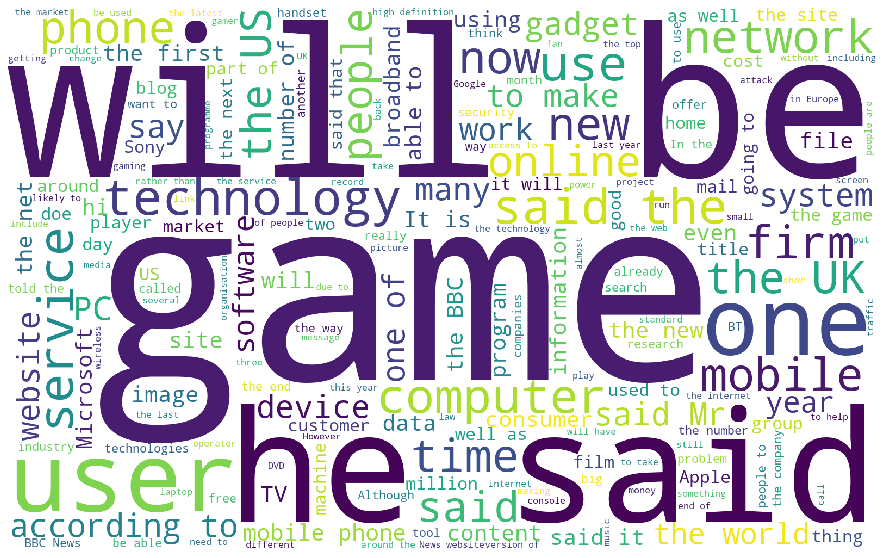

In [8]:
wordcloud_gen("tech")

# 2 Classification



### Load our test and train datasets.

In [2]:
import pandas as pd



from sklearn.metrics import make_scorer,    \
                            accuracy_score, \
                            precision_score,\
                            recall_score,   \
                            f1_score,       \
                            classification_report

train_set = pd.read_csv("train_set.tsv", sep='\t', encoding = 'ANSI')
test_set = pd.read_csv("test_set.tsv", sep='\t', encoding = 'ANSI')
test_labels = pd.read_csv("test_labels.tsv", sep='\t', encoding = 'ANSI')

Keep only the content and category columns.

In [3]:
train_content = train_set['content']
train_labels = train_set['category']
test_content = test_set['content']
test_categories = test_labels['category']

### Encode the train and test labels using sklearn.preprocessing.LabelEncoder

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_categories)

## 2.1 Transform our text data using CountVectorizer

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vec = CountVectorizer(max_features=1000,ngram_range=(1,2))

cv_train_content = count_vec.fit_transform(train_content)
cv_test_content = count_vec.transform(test_content)

### KNNClassifier prototype

Here we implemented a simple classifier for the K Nearest Neighbor estimator. It uses the mahnattan distance metric to produce the distances between each article pair. But this estimator is not qualified for the sklearn's cross_validate function, so we tried to make one on our own.

In [7]:
from sklearn.metrics.pairwise import manhattan_distances
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split
class KNNClassifier():
    
    def __init__(self, k=5,verbose=False):
        self.n_neighbors = k
        self.verbose = verbose
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        
        final_output = []
        dis = manhattan_distances(X_test,self.X_train)
        """ For every document in the test set, find its k nearest other documents."""
        for i in range(X_test.shape[0]):
            k_nearest_indices = np.argpartition(dis[i], self.n_neighbors)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices].tolist()
            
            i_label = max(set(k_nearest_labels), key = k_nearest_labels.count)
            final_output.append(i_label)
        return final_output

def testOneFold(estimator,trainSet,testSet):
    tpCnt=0
    allCnt=0
    X_train, X_test, y_train, y_test = trainSet[:,0], testSet[:,0], trainSet[:,1], testSet[:,1]
    X_train, y_train = train_test_split(trainSet)
    X_train = sparse.csr_matrix(X_train)
    print(X_train.shape)
    clf = estimator
    clf.fit(trainSet,train_labels)
    predicts = clf.predict(testSet)
    print(precision_score(test_labels, knn_predicted_labels, average='macro'))
        

def cross_validation(estimator, X,Y,num_folds=5):
    print(type(X))
    train = np.array(list(zip(X,Y)))
    np.random.shuffle(train)
    foldsList = np.array_split(train, num_folds)
    
    for fold in range(num_folds):
        testSet=np.empty((0,train.shape[1]))
        trainSet=np.empty((0,train.shape[1]))
        
        for j in range(num_folds):
            if fold ==j:
                testSet=foldsList[fold]
            else:
                trainSet=np.concatenate((trainSet, foldsList[j]), axis=0)
        score = testOneFold(estimator,trainSet,testSet)
        scores += [score]
    mean_score = sum(scores)/len(scores)
    return mean_score

### Classifiers cross validation and Evaluating predicted results.

In [15]:
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

### 2.1.1 Support Vector Machine (SVM)

First we perform a grid search to tune the model and see which parameters work best.

In [16]:
svm_clf = SVC()


param_grid = {
            'kernel': ['rbf', 'linear'],
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(svm_clf, param_grid)

Fit the train data into the grid search and show the best parameters for the SVM classifier.

In [18]:
clf.fit(cv_train_content, train_labels)

In [ ]:
clf.best_params_

Once we've found the best parameters, use them to perform the cross validation and test evaluation.

In [19]:
svm_clf = SVC(kernel='rbf',C=1000, gamma=0.0001)
svm_clf.fit(cv_train_content, train_labels)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now perform a 10-Fold Cross Validation on the trained model.

In [20]:
svm_scores = cross_validate(svm_clf, cv_train_content, train_labels, scoring=scoring, cv=10)

In [21]:
for i in svm_scores:
    print(i,svm_scores[i].mean())

fit_time 3.589806151390076
score_time 0.5143268346786499
test_precision_macro 0.9395879389561307
test_recall_macro 0.9356126257133279
test_f1_macro 0.9363807107128773
test_accuracy 0.9382022471910112


We will proceed to predict the labels.

In [22]:
svm_predicted_labels = svm_clf.predict(cv_test_content)

In [23]:
print("precision:",precision_score(test_labels, svm_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, svm_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, svm_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, svm_predicted_labels))

precision: 0.9444030609508525
Recall: 0.9393500127323657
F1: 0.9410524792139288
Accuracy: 0.9415730337078652


### 2.1.2 Random Forest Classifier

In [24]:
rf_clf = RandomForestClassifier()

In [25]:
rf_clf.fit(cv_train_content, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
rf_scores = cross_validate(rf_clf, cv_train_content, train_labels, scoring=scoring, cv=10)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 3.8798773288726807
score_time 0.060036206245422365
test_precision_macro 0.9462489570981095
test_recall_macro 0.9403516305742669
test_f1_macro 0.9420398787511537
test_accuracy 0.9432584269662921


In [27]:
rd_predicted_labels = rf_clf.predict(cv_test_content)

In [28]:
print("precision:",precision_score(test_labels, rd_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, rd_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, rd_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, rd_predicted_labels))

precision: 0.9528615605240993
Recall: 0.9462764196587725
F1: 0.948830771690209
Accuracy: 0.9483146067415731


### 2.1.3 Multinomial Naive Bayes

In [29]:
mnb_clf = MultinomialNB()

In [30]:
mnb_clf.fit(cv_train_content, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
rf_scores = cross_validate(mnb_clf, cv_train_content, train_labels, scoring=scoring, cv=10)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.014512467384338378
score_time 0.012069272994995116
test_precision_macro 0.9409873205755763
test_recall_macro 0.9409317740042159
test_f1_macro 0.940067530716344
test_accuracy 0.9421348314606741


In [32]:
mnb_predicted_labels = mnb_clf.predict(cv_test_content)

In [33]:
print("precision:",precision_score(test_labels, mnb_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, mnb_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, mnb_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, mnb_predicted_labels))

precision: 0.9572734843437708
Recall: 0.9535727018079958
F1: 0.9550124840046875
Accuracy: 0.9550561797752809


### 2.1.4 K Nearest Neighbours

In [8]:
knn_clf = KNNClassifier()
knn_clf.fit(cv_train_content,train_labels)
knn_predicted_labels = knn_clf.predict(cv_test_content)

print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.7932960644946775
Recall: 0.7241361089890501
F1: 0.724329060235987
Accuracy: 0.7415730337078652


## 2.2 Transform our text data using TF-IDF Vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=300, ngram_range=(1,2))

tfidf_train_content = tfidf_vec.fit_transform(train_content)
tfidf_test_content = tfidf_vec.transform(test_content)

### 2.2.1 Support Vector Machine (SVM)

In [36]:
param_grid = {
            'kernel': ['rbf', 'linear'],
            'C': [1e3, 5e3, 1e4, 5e4, 1e5],
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(), param_grid)

Fit the train data into the grid search and show the best parameters for the SVM classifier.

In [38]:
clf.fit(tfidf_train_content, train_labels)

In [ ]:
clf.best_params_

Once we've found the best parameters, use them to perform the cross validation and test evaluation.

In [39]:
svm_clf = SVC(kernel='rbf',C=1000, gamma=0.0005)

svm_clf.fit(tfidf_train_content, train_labels)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now perform a 10-Fold Cross Validation on the trained model.

In [40]:
svm_scores = cross_validate(svm_clf, tfidf_train_content, train_labels, scoring=scoring)

In [41]:
for i in svm_scores:
    print(i,svm_scores[i].mean())

fit_time 2.3734551429748536
score_time 0.6550500869750977
test_precision_macro 0.9250881404228114
test_recall_macro 0.9209471724809555
test_f1_macro 0.9223565056886887
test_accuracy 0.9241573033707866


We will proceed to predict the labels.

In [42]:
svm_predicted_labels = svm_clf.predict(tfidf_test_content)

In [43]:
print("precision:",precision_score(test_labels, svm_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, svm_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, svm_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, svm_predicted_labels))

precision: 0.9339079548322168
Recall: 0.9274738986503692
F1: 0.9295539975803905
Accuracy: 0.9303370786516854


### 2.2.2 Random Forest Classifier

In [44]:
rf_clf = RandomForestClassifier()

In [45]:
rf_clf.fit(tfidf_train_content, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
rf_scores = cross_validate(rf_clf, tfidf_train_content, train_labels, scoring=scoring)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 3.7826000690460204
score_time 0.06641902923583984
test_precision_macro 0.917126211837138
test_recall_macro 0.9096741979027229
test_f1_macro 0.9117809981196483
test_accuracy 0.9134831460674157


In [47]:
rd_predicted_labels = rf_clf.predict(tfidf_test_content)

In [48]:
print("precision:",precision_score(test_labels, rd_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, rd_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, rd_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, rd_predicted_labels))

precision: 0.9517585751758769
Recall: 0.9435816144639674
F1: 0.9467913107680463
Accuracy: 0.946067415730337


### 2.2.3 Multinomial Naive Bayes

In [49]:
mnb_clf = MultinomialNB()

In [50]:
mnb_clf.fit(tfidf_train_content, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
rf_scores = cross_validate(mnb_clf, tfidf_train_content, train_labels, scoring=scoring)
for i in rf_scores:
    print(i,rf_scores[i].mean())

fit_time 0.005185461044311524
score_time 0.004987382888793945
test_precision_macro 0.903356471962496
test_recall_macro 0.8939455371522904
test_f1_macro 0.8969546226322718
test_accuracy 0.9


In [52]:
mnb_predicted_labels = mnb_clf.predict(tfidf_test_content)

In [53]:
print("precision:",precision_score(test_labels, mnb_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, mnb_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, mnb_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, mnb_predicted_labels))

precision: 0.9042890039878501
Recall: 0.8848115609880315
F1: 0.8910938290479095
Accuracy: 0.8921348314606742


### 2.2.4 K Nearest Neighbours

In [54]:
knn_clf = KNNClassifier()
knn_clf.fit(tfidf_train_content,train_labels)



In [9]:
cross_validation(knn_clf, tfidf_train_content, train_labels)

NameError: name 'tfidf_train_content' is not defined

In [56]:
pred = knn_clf.predict(tfidf_test_content)
knn_predicted_labels = knn_clf.predict(tfidf_test_content)

print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.8542087208180977
Recall: 0.8454590017825312
F1: 0.8444131508008507
Accuracy: 0.8471910112359551


# 3 Beat the Benchmark

We chose to improve the model based on Multinomial Naive Bayes.

### Function prototype for text preprocessing.

<span style="color:DeepPink">**preprocess_article**</span>**(text)**  
&nbsp;&nbsp;Removes special characters from a given string object, removes stop words and lematizes words using WordNetLematizer().  
&nbsp;&nbsp;&nbsp;**Parameters: &nbsp;&nbsp;&nbsp;text : str**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
String object to process. 

&nbsp;&nbsp;&nbsp;**Returns: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;text : str**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Lowercase lematized string object without stopwords and several special characters.

In [57]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from nltk.stem import WordNetLemmatizer
import re

wordnet_lemmatizer = WordNetLemmatizer()

""" Make sure that the text parameter and return variable are of string type. """
def preprocess_article(text: str) -> str:
    # Remove newlines and \r characters.
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
    # Remove quotes
    text = text.replace('"', ' ')
   
    # Convert text to lowercase.
    text = text.lower()
    
    # Remove punctuation and many special characters.
    text = text.translate(str.maketrans('', '', '!?:\';.,[]()@#$%^&*Â£'))
   
    # Remove terminating 's characters.
    text = text.replace("'s", "")

    # Remove stop words. Note: do this first and then lemmatize because lemmatizing
    # can change words like 'has' to 'ha'.
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lematize text with WordNetLemmatizer().
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split(' ')])
    
    # Remove all words with numbers in them (ie. 400bn, 512kbps etc.) .
    text = re.sub(r'\w*\d\w*', '', text).strip()
    
    return text

In [58]:
train_content = train_content.apply(preprocess_article)
test_content = test_content.apply(preprocess_article)

Transform the train and test contents using tfidf vectorizer.

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

tfidf_train_content = tfidf_vec.fit_transform(train_content)
tfidf_test_content = tfidf_vec.transform(test_content)

We chose to use our own K Nearest Neighbor classifier to further improve  our results.

In [60]:
knn_clf = KNNClassifier()
knn_clf.fit(tfidf_train_content,train_labels)
knn_predicted_labels = knn_clf.predict(tfidf_test_content)

print("precision:",precision_score(test_labels, knn_predicted_labels, average='macro'))
print("Recall:",recall_score(test_labels, knn_predicted_labels, average='macro'))
print("F1:",f1_score(test_labels, knn_predicted_labels, average='macro'))
print("Accuracy:",accuracy_score(test_labels, knn_predicted_labels))

precision: 0.9391417087090762
Recall: 0.9241010949834478
F1: 0.9295048766311552
Accuracy: 0.9280898876404494


# 4 Clustering

We will use the preprocessed data from the Beat the Benchmark in both word count representations and TF-IDF.

In [61]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

We apply Cosine Similarity to the training data transformed by Count Vectorizer.

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
cv_vec = CountVectorizer(max_features=1000, ngram_range=(1,2))

cv_train_content = cv_vec.fit_transform(train_content)
cv_test_content = cv_vec.transform(test_content)

cv_data = cosine_similarity(cv_train_content)

We use PCA method on our training data and fit them to KMeans.

In [63]:
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD

pca = PCA(n_components=2).fit(cv_data)
data2D = pca.transform(cv_data)
random_state = np.random.RandomState(0)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=3, random_state=random_state).fit(data2D)

Now we visualize the text distribution and the corresponding clusters.

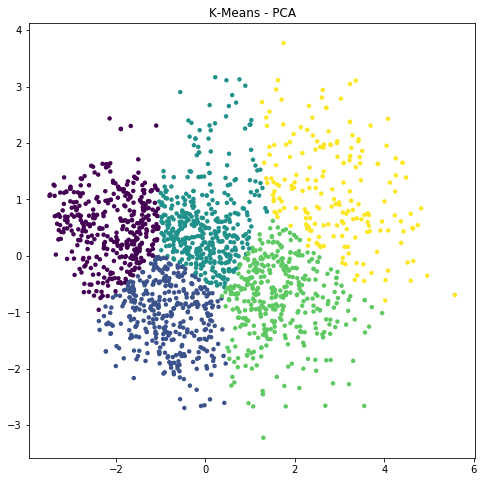

In [64]:
plt.figure(figsize=(8,8))
plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)
plt.title('K-Means - PCA')
plt.show()

Same process but on the tf-idf text represantation.

In [65]:
tfidf_data = cosine_similarity(tfidf_train_content)

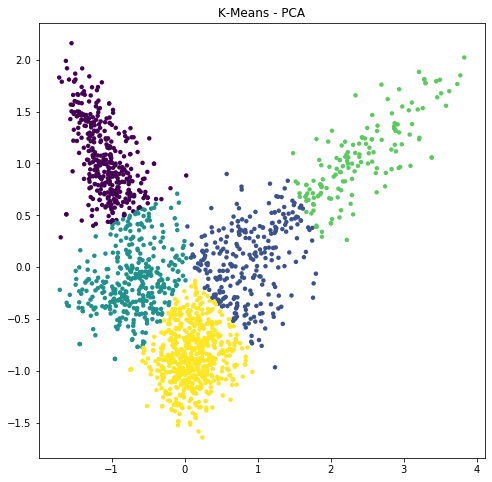

In [66]:
pca = PCA(n_components=2).fit(tfidf_data)
data2D = pca.transform(tfidf_data)
random_state = np.random.RandomState(0)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=3, random_state=random_state).fit(data2D)
plt.figure(figsize=(8,8))
plt.scatter(data2D[:, 0], data2D[:, 1], c=kmeans.labels_, edgecolor='',s=20)
plt.title('K-Means - PCA')
plt.show()